In [8]:
import numpy as np

from pysketcher import (
    Curve,
    Figure,
    Force,
    LinearDimension,
    Moment,
    Point,
    Rectangle,
    SimpleSupport,
    Style,
    Text,
    UniformLoad,
)
from pysketcher.backend.matplotlib import MatplotlibBackend
from pysketcher.composition import Composition



C:\Users\Felipes PC\anaconda3\lib\site-packages\pysketcher\backend\matplotlib\_matplotlib_backend.py:68: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



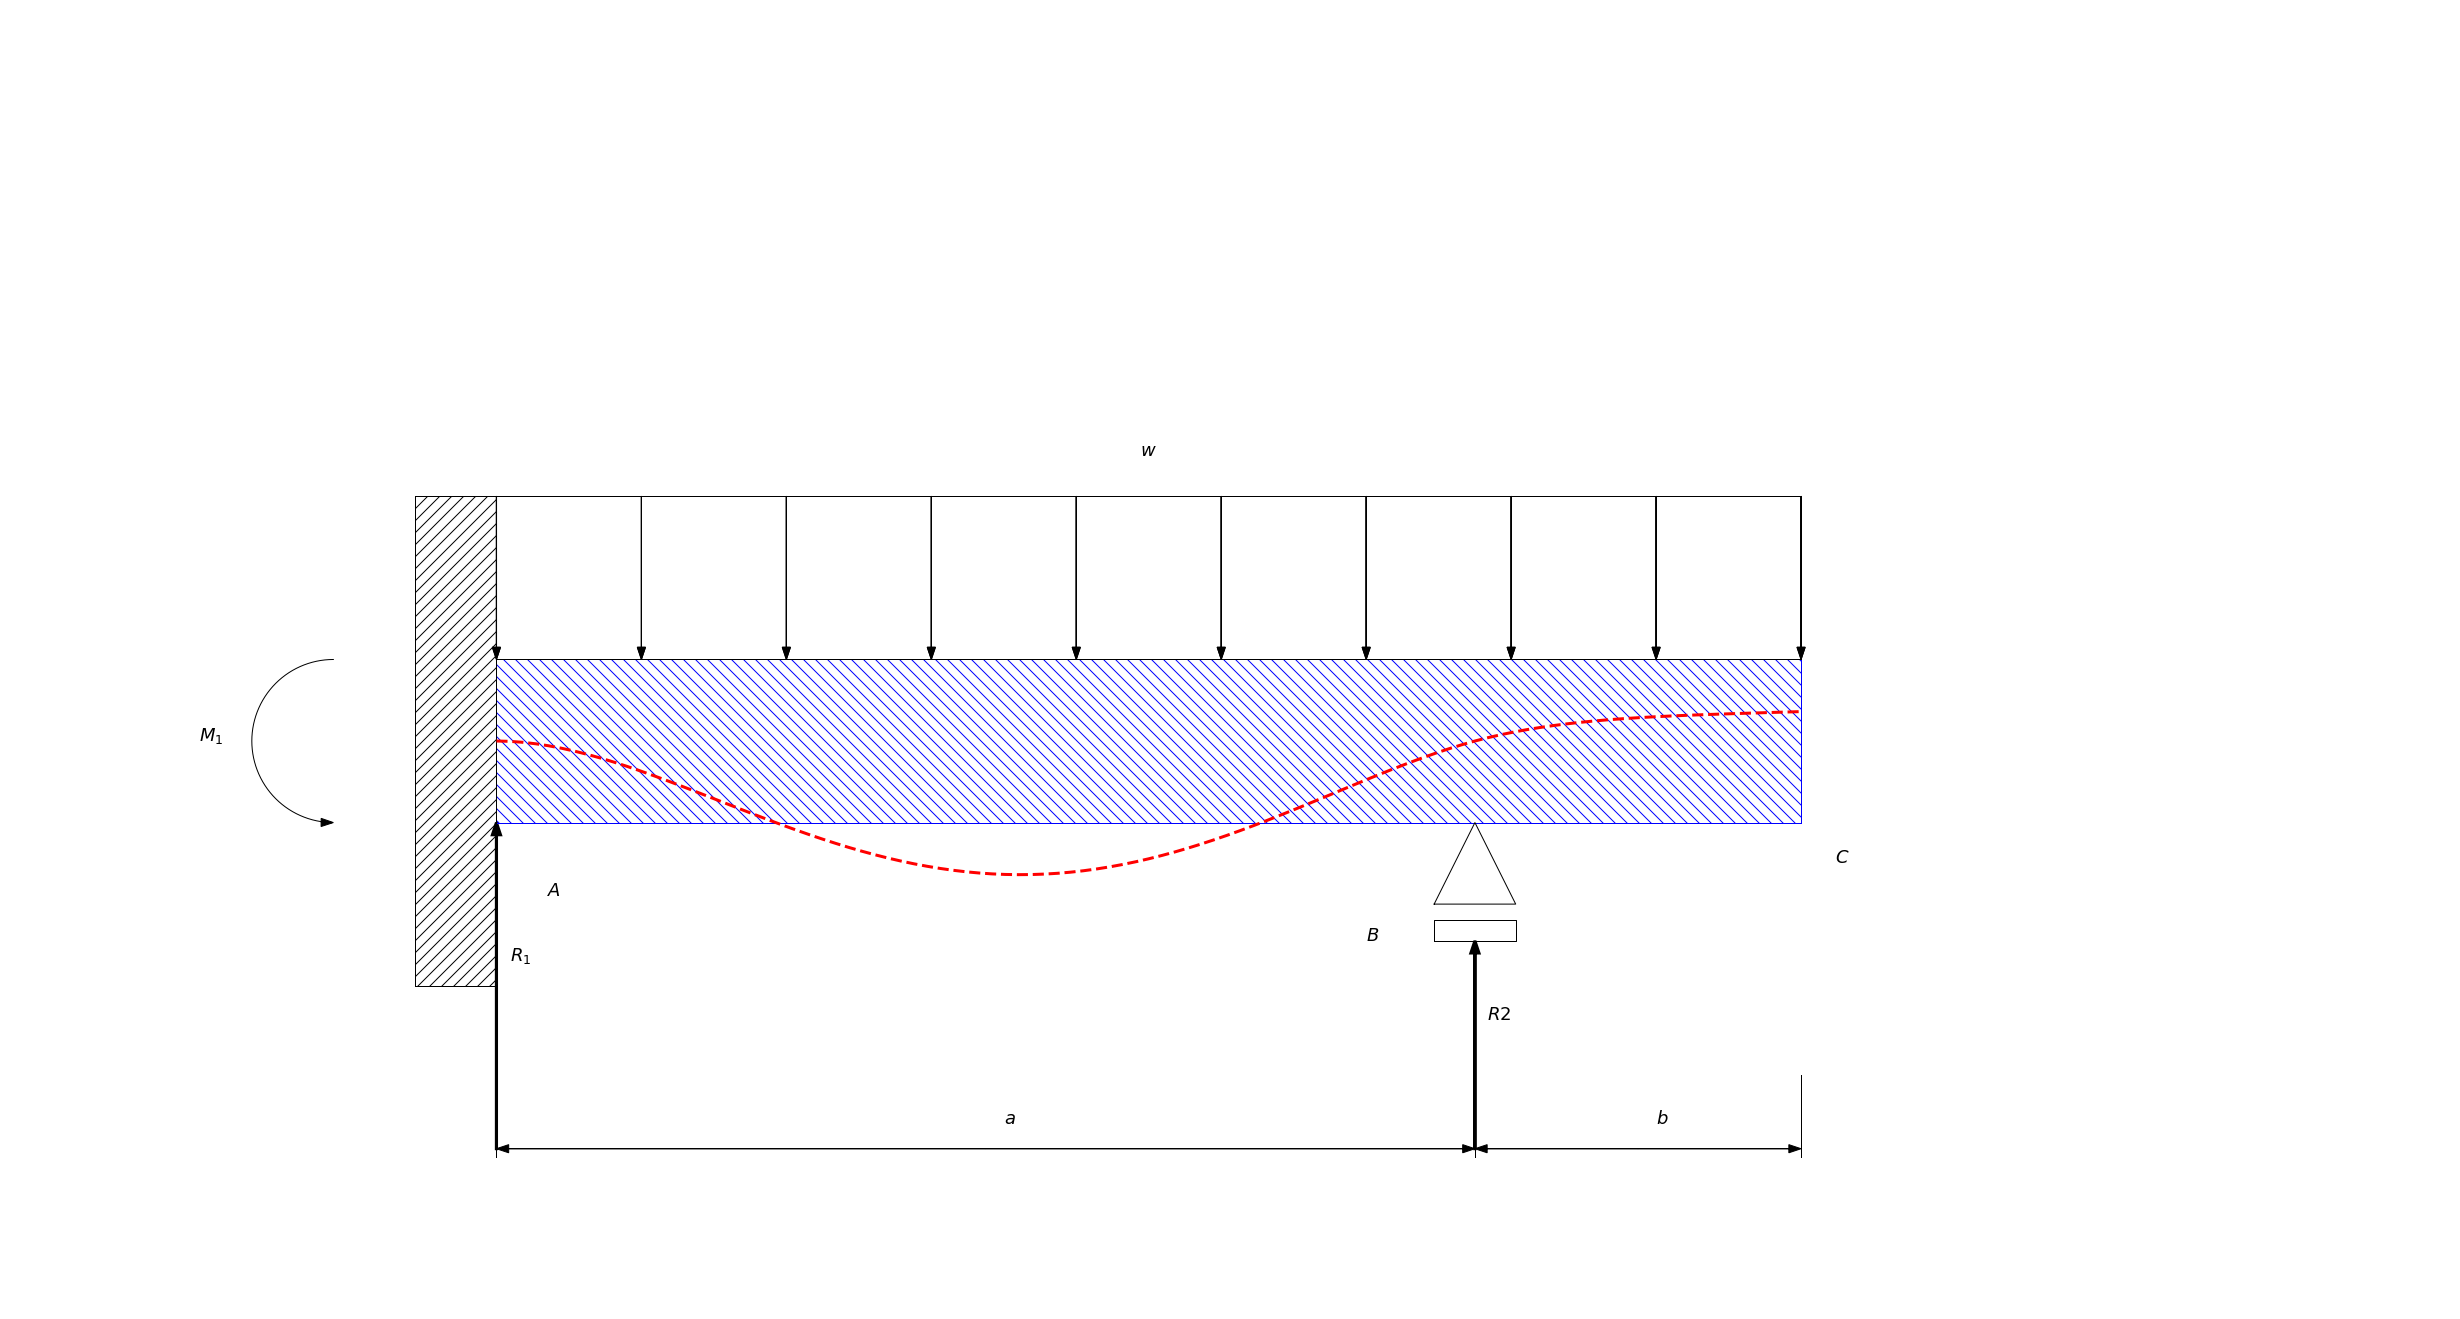

In [74]:
"""A more sophisticated beam than in beam1.py."""

import logging

import numpy as np

from pysketcher import (
    Curve,
    Figure,
    Force,
    LinearDimension,
    Moment,
    Point,
    Rectangle,
    SimpleSupport,
    Style,
    Text,
    UniformLoad,
)
from pysketcher.backend.matplotlib import MatplotlibBackend
from pysketcher.composition import Composition

logging.basicConfig(level=logging.INFO)


def main() -> None:
    L = 8.0
    a = 3 * L / 4
    b = L - a
    H = 1.0
    A = Point(0.0, 3.0)

    fig = Figure(-3, A.x + 1.5 * L, 0, A.y + 5 * H, MatplotlibBackend)

    beam = (
        Rectangle(A, L, H)
        .set_fill_pattern(Style.FillPattern.UP_RIGHT_TO_LEFT)
        .set_line_color(Style.Color.BLUE)
    )

    h = L / 16  # size of support, clamped wall etc

    clamped = Rectangle(A - Point(h, 0) - Point(0, 2 * h), h, 6 * h).set_fill_pattern(
        Style.FillPattern.UP_LEFT_TO_RIGHT
    )

    load = UniformLoad(A + Point(0, H), L, H)
    load.set_line_width(1).set_line_color(Style.Color.BLACK)
    load_text = Text("$w$", load.mid_top + Point(0, h / 2.0))

    B = A + Point(a, 0)
    C = B + Point(b, 0)

    support = SimpleSupport(B, h)  # pt B is simply supported

    R1 = Force(
        "$R_1$",
        A - Point(0, 2 * H),
        A,
        # start_spacing=0.3
    )
    R1.set_line_width(3).set_line_color(Style.Color.BLACK)
    R2 = Force(
        "$R2$",
        B - Point(0, 2 * H),
        support.mid_support,
    )
    R2.set_line_width(3).set_line_color(Style.Color.BLACK)
    M1 = Moment(
        "$M_1$",
        center=A + Point(-H, H / 2),
        radius=H / 2,
    )
    M1.line_color = "black"

    ab_level = Point(0, 3 * h)
    a_dim = LinearDimension("$a$", A - ab_level, B - ab_level)
    b_dim = LinearDimension("$b$", B - ab_level, C - ab_level)
    dims = Composition({"a": a_dim, "b": b_dim})
    symbols = Composition(
        {
            "R1": R1,
            "R2": R2,
            "M1": M1,
            "w": load,
            "w text": load_text,
            "A": Text("$A$", A + Point(0.7 * h, -0.9 * h)),
            "B": Text("$B$", support.mid_support - Point(1.25 * h, 0)),
            "C": Text("$C$", C + Point(h / 2, -h / 2)),
        }
    )

    annotations = Composition({"dims": dims, "symbols": symbols})
    beam = Composition(
        {"beam": beam, "support": support, "clamped end": clamped, "load": load}
    )

    def deflection(x, a, b, w) -> float:
        R1 = 5.0 / 8 * w * a - 3 * w * b ** 2 / (4 * a)
        R2 = 3.0 / 8 * w * a + w * b + 3 * w * b ** 2 / (4 * a)
        M1 = R1 * a / 3 - w * a ** 2 / 12
        y = (
            -(M1 / 2.0) * x ** 2
            + 1.0 / 6 * R1 * x ** 3
            - w / 24.0 * x ** 4
            + 1.0 / 6 * R2 * np.where(x > a, 1, 0) * (x - a) ** 3
        )
        return y

    xs = np.linspace(0, L, 101)
    ys = deflection(xs, a, b, w=1.0)
    ys /= abs(ys.max() - ys.min())
    ys += A.y + H / 2
    points = Point.from_coordinate_lists(xs, ys)

    elastic_line = (
        Curve(points)
        .set_line_color(Style.Color.RED)
        .set_line_style(Style.LineStyle.DASHED)
        .set_line_width(3)
    )

    fig.add(beam)
    fig.add(annotations)
    fig.add(elastic_line)
    fig.show()


if __name__ == "__main__":
    main()

# MAIN CODE

In [273]:
import numpy as np
import pandas as pd
from pysketcher import (
    Curve,
    Figure,
    Force,
    LinearDimension,
    Moment,
    Point,
    Rectangle,
    SimpleSupport,
    Style,
    Text,
    UniformLoad,
    Circle)
from pysketcher.backend.matplotlib import MatplotlibBackend
from pysketcher.composition import Composition
import plotly.graph_objects as go

class Beam:    
    """
    Creates a customizable beam object, also includes methods to present the Freebody Diagram
    and perform calculations as desired
    """
    
    x_pos = 2.0
    y_pos = 3.0
    p0 = Point(x_pos, y_pos)
    scaled_length= 10
    
    def __init__(self, length, height):
        """
        Initializing the beam properties, additional properties will be added on top
        as the user desires.
        length: [m]
        height: [m]
        """
        
        self.length = length
        self.height = 1
        self.beam_height = height
        self.main = Rectangle(self.p0, self.scaled_length, height).set_fill_pattern(Style.FillPattern.UP_LEFT_TO_RIGHT)
        self.composition={"main": self.main}
        #self.force_dictionary={}
        self.force_dictionary={'magnitude':[],'position':[],'type':[]}
        #self.moment_dictionary={}
        self.moment_dictionary={'magnitude':[],'position':[],'name':[]}
        #self.support_dictionary={}
        self.support_dictionary={'magnitude':[],'position':[],'type':[]}
        self.UDL_dictionary = {'magnitude':[],'position':[],'distributed_load':[], 'end_position':[]}
        
    def point_force(self,name,position,magnitude):
        """
        Add a point force at any point along the beam, forces have to be named.
        Throw error for forces outside the beams length
        position: [m]
        magnitude: [N]
        """
        if position>self.length or position<0:
            raise ValueError("Force must be placed within the beam")
            
        scaled= (position/self.length)*self.scaled_length
        F_pt = Point(self.p0.x + scaled, self.p0.y + self.height)
        self.force_dictionary['magnitude'].append(-1*magnitude)
        self.force_dictionary['position'].append(position)
        self.force_dictionary['type'].append('PT')
        force_drawing = Force(f"${name}$", F_pt + Point(0, self.height), F_pt).set_line_width(3)
        self.composition[name] = force_drawing
        

        
    def uniform_load(self,name,start,end,distributed_load):
        """
        Adds a distributed load ontop of the beam. The force has to be named.
        An error is thrown if the uniform load is incorrectly defined or placed outside of bounds
        distributed load: [N/m]
        start and end: [m]
        """
        
        if start>self.length or start<0 or end > self.length:
            raise ValueError("Force must be placed within the beam")
        elif end<=start:
            raise ValueError("Force must end else where")
        scaled_start= (start/self.length)*self.scaled_length    
        scaled_end= (end/self.length)*self.scaled_length       
        load = UniformLoad(self.p0 + Point(scaled_start, self.height), scaled_end - scaled_start, self.height)
        load_text = Text("$w$", load.mid_top)
        magnitude = (end-start)*distributed_load
        position = (end-start)/2 + start
        
        self.force_dictionary['magnitude'].append(-1*magnitude)
        self.force_dictionary['position'].append(position)
        self.force_dictionary['type'].append('UDL')
        self.UDL_dictionary['magnitude'].append(-1*magnitude)
        self.UDL_dictionary['position'].append(start)
        self.UDL_dictionary['distributed_load'].append(-1*distributed_load)
        self.UDL_dictionary['end_position'].append(end)
        self.composition[name] = load
        self.composition['text'] = load_text
    def moment(self,name,position,magnitude):
        """
        Add a couple or moment anywhere along the beam.
        position: [m]
        magnitude: [N*m]
        """
        
        if position>self.length or position<0:
            raise ValueError("Moment must be placed within the beam")
        scaled= (position/self.length)*self.scaled_length    
        M1 = Moment(f"${name}$",center=self.p0 + Point(scaled, self.height/2),
                        radius= self.height/ 2)
        self.composition[name] = M1
        self.moment_dictionary['magnitude'].append(magnitude)
        self.moment_dictionary['position'].append(position)
        self.moment_dictionary['name'].append(name)
        #self.moment_dictionary[name] = [magnitude,position,'moment']

#     def fixed_support(self,name,position):
#         """
#         Adds a fixed support along the beam. This support has reaction forces
#         in both the vertical and horizontal directions.
#         Only one fixed support can be placed or the problem becomes
#         statically indeterminate.
#         position: [m]
#         """
        
#         if self.fixed_support_exist == True:
#             raise ValueError("Only one fixed support can exist for the beam to be statically determinate")
#         if position>self.length or position<0:
#             raise ValueError("Support must be placed on the beam")
#         scaled= (position/self.length)*self.scaled_length    
#         self.fixed_support_exist=True
#         ground_support = SimpleSupport(self.p0 + Point(scaled, 0), self.scaled_length/22)  # pt B is simply supported
#         self.support_dictionary['magnitude'].append(None)
#         self.support_dictionary['position'].append(position)
#         self.support_dictionary['type'].append('fixed')
#         #self.support_dictionary[name] = [None,position,'support']
#         self.composition[name] = ground_support
        
#     def roller_support(self,name,position):
#         """
#         Adds a roller support along the beam. This support has reaction forces
#         in only the vertical direction.
#         As many roller supports can be placed as desired.
#         position: [m]
#         """
        
#         if self.roller_support_exist == True:
#             raise ValueError("Only one roller support can exist for the beam to be statically determinate")
#         if position>self.length or position<0:
#             raise ValueError("Support must be placed on the beam")
#         scaled= (position/self.length)*10
#         self.roller_support_exist=True
#         roller = Circle(self.p0 + Point(scaled, -self.scaled_length/30), self.scaled_length/30)
#         self.support_dictionary['magnitude'].append(None)
#         self.support_dictionary['position'].append(position)
#         self.support_dictionary['type'].append('roller')
#         #self.support_dictionary[name] = [None,position,'support']
#         self.composition[name] = roller
        
    def show_beam(self):
        """
        This method takes all the previously used methods to show the beam they've created.
        """
        scaled= self.scaled_length    
        #Consider only allowing show_beam to run once there is a fixed support and roller support added
        #into the problem. This consideration should also be added in for when calculations are ready
        #to be called as a method. I've got to limit when calculations can realistically be started.
        beam = Composition(self.composition)
        fig = Figure(0, self.x_pos + 1.2 * scaled, 0, self.y_pos + 5 * self.height, MatplotlibBackend)
        fig.add(beam)
        fig.show()
        
    def point_force_calculation(self,current_position,start_position,magnitude):
        """
        Calculates the shear force and moment that would arise from a single point load.
        """
        if current_position >= start_position:
            #index value based on whicever force were on
            shear = magnitude
            moment = magnitude*(current_position - start_position)
        else:
            shear = 0 
            moment = 0
        return shear,moment

    def UDL_calculation(self,current_position,start_position,end_position,distributed_load):
        """
        Calculates the shear force and moment that would arise from a 
        uniformly distributed load.
        """
        
        if (current_position >= start_position) and (current_position<= end_position):
            #index value based on whicever force were on
            shear = distributed_load*(current_position - start_position)
            moment = 0.5*distributed_load*((current_position - start_position)**2)
        elif current_position> end_position:
            shear = distributed_load*(end_position-start_position)
            #moment = shear*(current_position-((end_position-start_position)))
            moment = shear*(current_position-(start_position+ (end_position-start_position)/2))
        else:
            shear = 0 
            moment = 0
        return shear,moment

    def moment_calculation(self,current_position,start_position,magnitude):
        """
        Calculates the moment that would arise from a couple placed on the beam
        """
        if current_position >= start_position:
            #index value based on whicever force were on
            moment = -1*magnitude
        else:
            moment = 0
        return moment  
    
#     def calculate_forces(self):
#         """
#         Calculates the support reactions for the beam.
#         Solves the system of equations involved from creating a sum of forces,
#         and sum of moments.
#         """
#         if (self.fixed_support_exist != True or self.roller_support_exist!= True):
#             raise ValueError("The beam is not static and requires an additional support")
#         A=np.ones([2,len(self.support_dictionary['magnitude'])])
#         B=np.empty([1,len(self.support_dictionary['magnitude'])])
#         force= pd.DataFrame.from_dict(self.force_dictionary)
#         moment= pd.DataFrame.from_dict(self.moment_dictionary)
#         support = pd.DataFrame.from_dict(self.support_dictionary)
#         #Rearranging support dataframe so 'Fixed is always first'
#         support= (support.sort_values('type')).reset_index(drop=True)
#         fixed_support_position = support['position'][0]
        
#         #Fixed Support Position is the beginning of the lever arm. The lever arm
#         #is the distance from some force to the fixed support
#         #
#         sum_force_reactions = -1*force['magnitude'].sum()
        
#         #Calculating the moment generated by all forces placed along the beam.
#         force['moment'] = (force['position'] - fixed_support_position)*force['magnitude']
#         sum_moments_and_couples = -1*force['moment'].sum() - moment['magnitude'].sum()
        
#         B[0,0]= sum_force_reactions
#         B[0,1] = sum_moments_and_couples
#         A[1,0] = 0
#         A[1,1] = support['position'][1]
        
#         #Solving for support reactions and giving values to the support dictionary.
#         support['magnitude']= np.linalg.solve(A, np.transpose(B))
#         self.support_dictionary['magnitude'] = list(support['magnitude'])
        
    def shear_moment_calculation(self):
        """Utilizes all calculation methods to produce shear force and moment values.
        Uses the principle of support position to calculate values. Iterativerly
        calculates the forces at different positions along the beam."""
        #Preparing or editing existing dictionaries to start calculations
        self.calculate_forces()
        position_vector = np.linspace(0,self.length,1000)
        force= pd.DataFrame.from_dict(self.force_dictionary)
        force = force.loc[force["type"] == 'PT']
        moment_frame= pd.DataFrame.from_dict(self.moment_dictionary)
        dist = pd.DataFrame.from_dict(self.UDL_dictionary)
        support = pd.DataFrame.from_dict(self.support_dictionary)
        support.drop('type', inplace= True, axis=1)
        support['type']='PT'
        force = pd.concat([force, support], axis="rows")
        force = force.reset_index(drop=True)

        #Goes through the entire position vector to produce shear and moment values.
        shear = [0] * len(position_vector)
        moment =  shear.copy()
        for position_index, position in enumerate(position_vector):
            for index, row in force.iterrows():
                shear_iter, moment_iter = self.point_force_calculation(position,row['position'],row['magnitude'])
                shear[position_index] += shear_iter
                moment[position_index] += moment_iter
            for index, row in dist.iterrows():
                shear_iter,moment_iter = self.UDL_calculation(position,row['position'],row['end_position'],row['distributed_load'])
                shear[position_index] += shear_iter
                moment[position_index] += moment_iter
            for index, row in moment_frame.iterrows():
                moment_iter = self.moment_calculation(position,row['position'],row['magnitude'])
                moment[position_index] += moment_iter
                
        self.moment = moment
        self.shear= shear
        self.position_vector = position_vector
        
    def diagrams(self):
        """Uses the shear_moment_calculation method to solve for moment and shear values.
        These solved values are plotted with plotly"""
        self.shear_moment_calculation()
        
        position_vector=sick_beam.position_vector
        shear= sick_beam.shear
        moment= sick_beam.moment

        shear_diagram = go.Scatter(x=position_vector,y=shear,
                           mode = 'lines',
                           name = 'Shear Force',
                           fill='tozeroy',
                           line_color='blue',
                           fillcolor='light blue'
                           )
        moment_diagram = go.Scatter(x=position_vector,y=moment,
                                   mode = 'lines',
                                   name = 'Shear Force',
                                   fill='tozeroy',
                                   line_color='blue',
                                   fillcolor='light blue'
                                   )

        layout_shear= go.Layout(
                                title = {'text': "Shear Force Diagram",
                                         'x': 0.5},
                                xaxis = {'title':"Distance (m)",
                                        'range':[-1,self.length+1]},
                                yaxis = {'title':"Force (N)"}
                                )
        # layout_moment= go.Layout(title=go.layout.Title(text="Moment Diagram"))
        layout_moment= go.Layout(
                                title = {'text': "Moment Diagram",
                                         'x': 0.5},
                                xaxis = {'title':"Distance (m)",
                                        'range':[-1,self.length+1]},
                                yaxis = {'title':"Moment (Nm)"}
                                )
        fig_go_shear = go.Figure(data=shear_diagram,layout= layout_shear)
        fig_go_moment = go.Figure(data=moment_diagram,layout= layout_moment)

        sick_beam.show_beam()
        fig_go_shear.show( )
        fig_go_moment.show()

In [312]:
class Supported_Beam(Beam):    
    """
    Creates a customizable beam object, also includes methods to present the Freebody Diagram
    and perform calculations as desired
    """
    
    x_pos = 2.0
    y_pos = 3.0
    p0 = Point(x_pos, y_pos)
    scaled_length= 10
    
    def __init__(self, length, height):
        """
        Initializing the beam properties, additional properties will be added on top
        as the user desires.
        length: [m]
        height: [m]
        """
        self.length = length
        self.height = 1
        self.beam_height = height
        self.main = Rectangle(self.p0, self.scaled_length, height).set_fill_pattern(Style.FillPattern.UP_LEFT_TO_RIGHT)
        self.composition={"main": self.main}
        #self.force_dictionary={}
        self.force_dictionary={'magnitude':[],'position':[],'type':[]}
        #self.moment_dictionary={}
        self.moment_dictionary={'magnitude':[],'position':[],'name':[]}
        #self.support_dictionary={}
        self.support_dictionary={'magnitude':[],'position':[],'type':[]}
        self.UDL_dictionary = {'magnitude':[],'position':[],'distributed_load':[], 'end_position':[]}
        super().__init__(length, height)
        
        self.fixed_support_exist = False
        self.roller_support_exist = False
        
    def fixed_support(self,name,position):
        """
        Adds a fixed support along the beam. This support has reaction forces
        in both the vertical and horizontal directions.
        Only one fixed support can be placed or the problem becomes
        statically indeterminate.
        position: [m]
        """
        
        if self.fixed_support_exist == True:
            raise ValueError("Only one fixed support can exist for the beam to be statically determinate")
        if position>self.length or position<0:
            raise ValueError("Support must be placed on the beam")
        scaled= (position/self.length)*self.scaled_length    
        self.fixed_support_exist=True
        ground_support = SimpleSupport(self.p0 + Point(scaled, 0), self.scaled_length/22)  # pt B is simply supported
        self.support_dictionary['magnitude'].append(None)
        self.support_dictionary['position'].append(position)
        self.support_dictionary['type'].append('fixed')
        self.composition[name] = ground_support
        R1 = Force(f"${name}$",self.p0 + Point(scaled,0) - Point(0, 2 * self.height),ground_support.mid_support)
        R1.set_line_width(3).set_line_color(Style.Color.BLACK)
        self.composition["Fixed_ReactionForce"] = R1
        
    def roller_support(self,name,position):
        """
        Adds a roller support along the beam. This support has reaction forces
        in only the vertical direction.
        As many roller supports can be placed as desired.
        position: [m]
        """
        
        if self.roller_support_exist == True:
            raise ValueError("Only one roller support can exist for the beam to be statically determinate")
        if position>self.length or position<0:
            raise ValueError("Support must be placed on the beam")
        scaled= (position/self.length)*10
        self.roller_support_exist=True
        roller = Circle(self.p0 + Point(scaled, -self.scaled_length/30), self.scaled_length/30)
        self.support_dictionary['magnitude'].append(None)
        self.support_dictionary['position'].append(position)
        self.support_dictionary['type'].append('roller')
        self.composition[name] = roller  
        R2 = Force(f"${name}$",self.p0 + Point(scaled,0) - Point(0, 2 * self.height),roller.center - Point(0,roller.radius))
        R2.set_line_width(3).set_line_color(Style.Color.BLACK)
        self.composition["Roller_ReactionForce"] = R2
    def calculate_forces(self):
        """
        Calculates the support reactions for the beam.
        Solves the system of equations involved from creating a sum of forces,
        and sum of moments.
        """
        if (self.fixed_support_exist != True or self.roller_support_exist!= True):
            raise ValueError("The beam is not static and requires an additional support")
        A=np.ones([2,len(self.support_dictionary['magnitude'])])
        B=np.empty([1,len(self.support_dictionary['magnitude'])])
        force= pd.DataFrame.from_dict(self.force_dictionary)
        moment= pd.DataFrame.from_dict(self.moment_dictionary)
        support = pd.DataFrame.from_dict(self.support_dictionary)
        #Rearranging support dataframe so 'Fixed is always first'
        support= (support.sort_values('type')).reset_index(drop=True)
        fixed_support_position = support['position'][0]
        
        #Fixed Support Position is the beginning of the lever arm. The lever arm
        #is the distance from some force to the fixed support
        #
        sum_force_reactions = -1*force['magnitude'].sum()
        
        #Calculating the moment generated by all forces placed along the beam.
        force['moment'] = (force['position'] - fixed_support_position)*force['magnitude']
        sum_moments_and_couples = -1*force['moment'].sum() - moment['magnitude'].sum()
        
        B[0,0]= sum_force_reactions
        B[0,1] = sum_moments_and_couples
        A[1,0] = 0
        A[1,1] = support['position'][1]
        
        #Solving for support reactions and giving values to the support dictionary.
        support['magnitude']= np.linalg.solve(A, np.transpose(B))
        self.support_dictionary['magnitude'] = list(support['magnitude'])

In [323]:
class Cantilever_Beam(Beam):    
    """
    Creates a customizable beam object, also includes methods to present the Freebody Diagram
    and perform calculations as desired
    """
    
    x_pos = 2.0
    y_pos = 3.0
    p0 = Point(x_pos, y_pos)
    scaled_length= 10
    
    def __init__(self, length, height):
        """
        Initializing the beam properties, additional properties will be added on top
        as the user desires.
        length: [m]
        height: [m]
        """
        
        self.length = length
        self.height = 1
        self.beam_height = height
        self.main = Rectangle(self.p0, self.scaled_length, height).set_fill_pattern(Style.FillPattern.UP_LEFT_TO_RIGHT)
        self.composition={"main": self.main}
        #self.force_dictionary={}
        self.force_dictionary={'magnitude':[],'position':[],'type':[]}
        #self.moment_dictionary={}
        self.moment_dictionary={'magnitude':[],'position':[],'name':[]}
        #self.support_dictionary={}
        self.support_dictionary={'magnitude':[],'position':[],'type':[]}
        
        self.UDL_dictionary = {'magnitude':[],'position':[],'distributed_load':[], 'end_position':[]}

        super().__init__(length, height)

        clamped = Rectangle(self.p0 - Point(1, 0) - Point(0, 2 * 1), 1, 5 * 1).set_fill_pattern(
        Style.FillPattern.UP_LEFT_TO_RIGHT)
        self.composition['clamped']= clamped
        reaction_force= Force("$R_1$",self.p0 - Point(0, 2 * self.height),self.p0)
        reaction_force.set_line_width(3).set_line_color(Style.Color.BLACK)
        self.composition['Reaction']= reaction_force
        reaction_moment = Moment("$RM_1$",center=self.p0 + Point(0, self.height/ 2),
                                 radius=self.height/ 2)
        reaction_moment.line_color = "black"
        self.composition['Reaction_Moment']= reaction_moment
    def calculate_forces(self):
        """
            Calculates the support reactions for the beam.
            Solves the system of equations involved from creating a sum of forces,
            and sum of moments.
        """

        force= pd.DataFrame.from_dict(self.force_dictionary)
        moment= pd.DataFrame.from_dict(self.moment_dictionary)
        support = pd.DataFrame.from_dict(self.support_dictionary)
        #Rearranging support dataframe so 'Fixed is always first'
        support= (support.sort_values('type')).reset_index(drop=True)
        fixed_support_position = 0
        
        #Fixed Support Position is the beginning of the lever arm. The lever arm
        #is the distance from some force to the fixed support
        #
        sum_force_reactions = -1*force['magnitude'].sum()
        
        #Calculating the moment generated by all forces placed along the beam.
        force['moment'] = (force['position'] - fixed_support_position)*force['magnitude']
        sum_moments_and_couples = -1*force['moment'].sum() - moment['magnitude'].sum()
        
        self.moment_dictionary['magnitude'].append(sum_moments_and_couples)
        self.moment_dictionary['position'].append(0)
        self.moment_dictionary['name'].append("M")
    
        #Solving for support reactions and giving values to the support dictionary.
        self.support_dictionary['magnitude'].append(sum_force_reactions)
        self.support_dictionary['position'].append(0)
        self.support_dictionary['type'].append('fixed')

Create a way for multiple point forces to be added. I add one point force, and maybe later I add another. It should show both point forces I added.

C:\Users\Felipes PC\anaconda3\lib\site-packages\pysketcher\backend\matplotlib\_matplotlib_backend.py:68: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



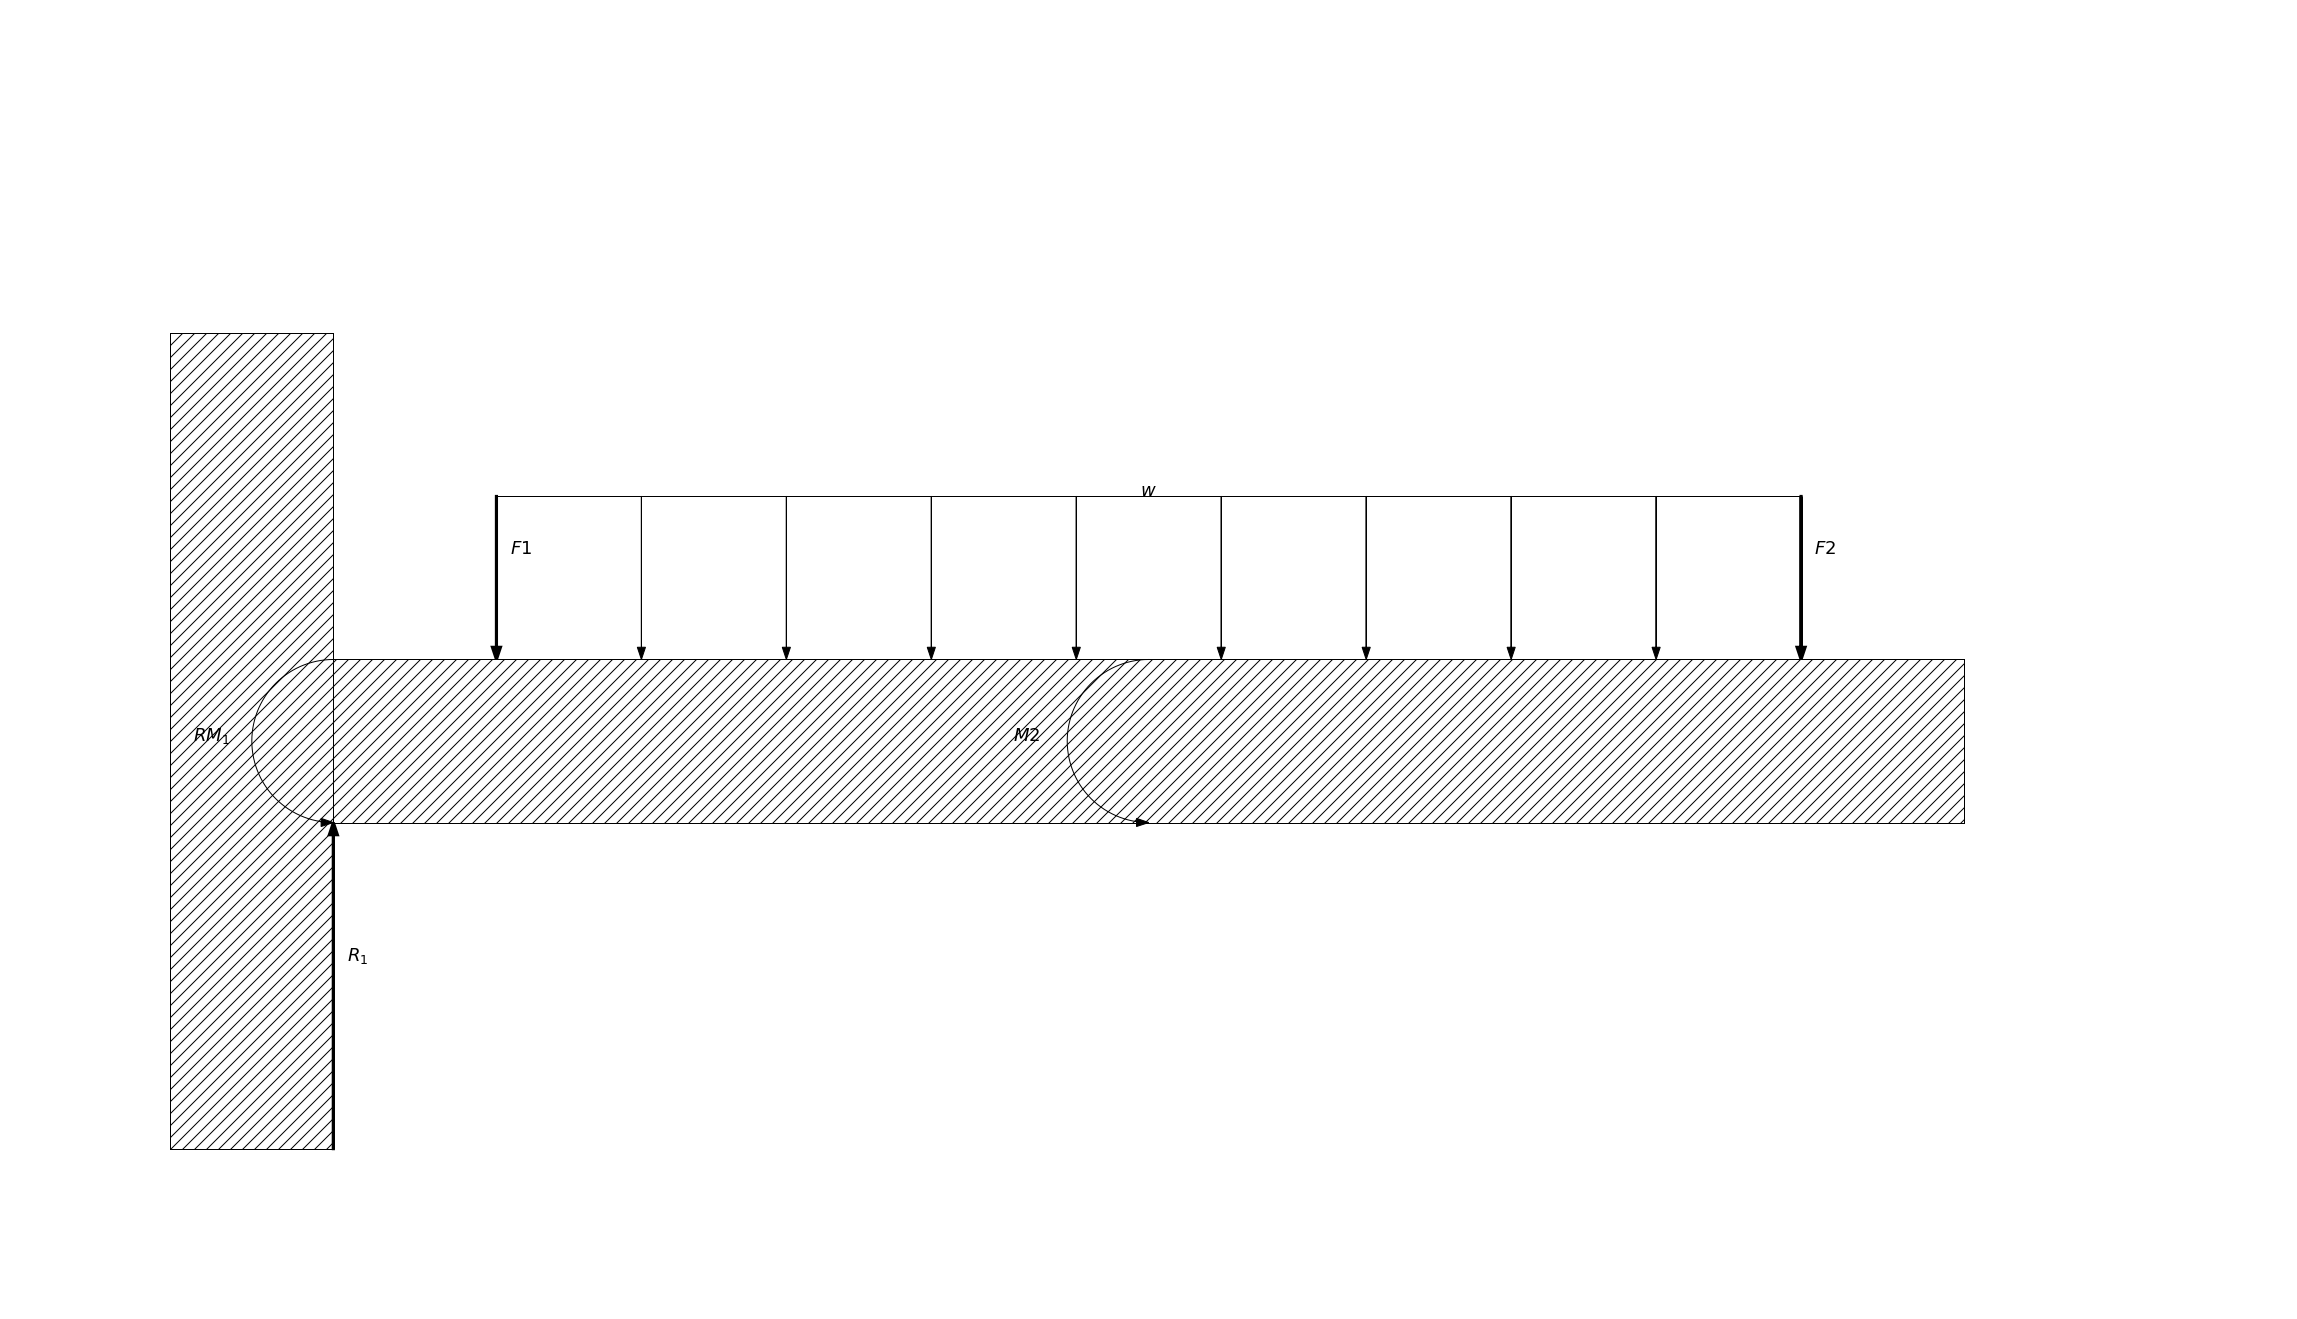

In [324]:
#Create the Beam Object
# sick_beam = Supported_Beam(length = 20, height = 1)
sick_beam = Cantilever_Beam(length = 20, height = 1)
#Adding forces onto the beam. It doesn't matter that order in which use these methods. 
sick_beam.point_force("F1",position = 2,magnitude= 20)
sick_beam.point_force("F2",position = 18,magnitude= 20)
sick_beam.uniform_load('UF1',start= 2,end = 18, distributed_load = 10)

#Adding Supports underneath the beam. The problem is limited to one fixed support
#Since adding more will make the problem statically indeterminate.
# sick_beam.fixed_support('SUP1', position= 2)
# sick_beam.roller_support('SUP2',position= 6)

#Add a couple onto the beam
sick_beam.moment('M2',position=10,magnitude=10)

#Once you've added the methods desired you can take a look at how the beam looks.
sick_beam.force_dictionary
sick_beam.moment_dictionary
sick_beam.diagrams()

 # CURRENT PROJECT

C:\Users\Felipes PC\anaconda3\lib\site-packages\pysketcher\backend\matplotlib\_matplotlib_backend.py:68: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



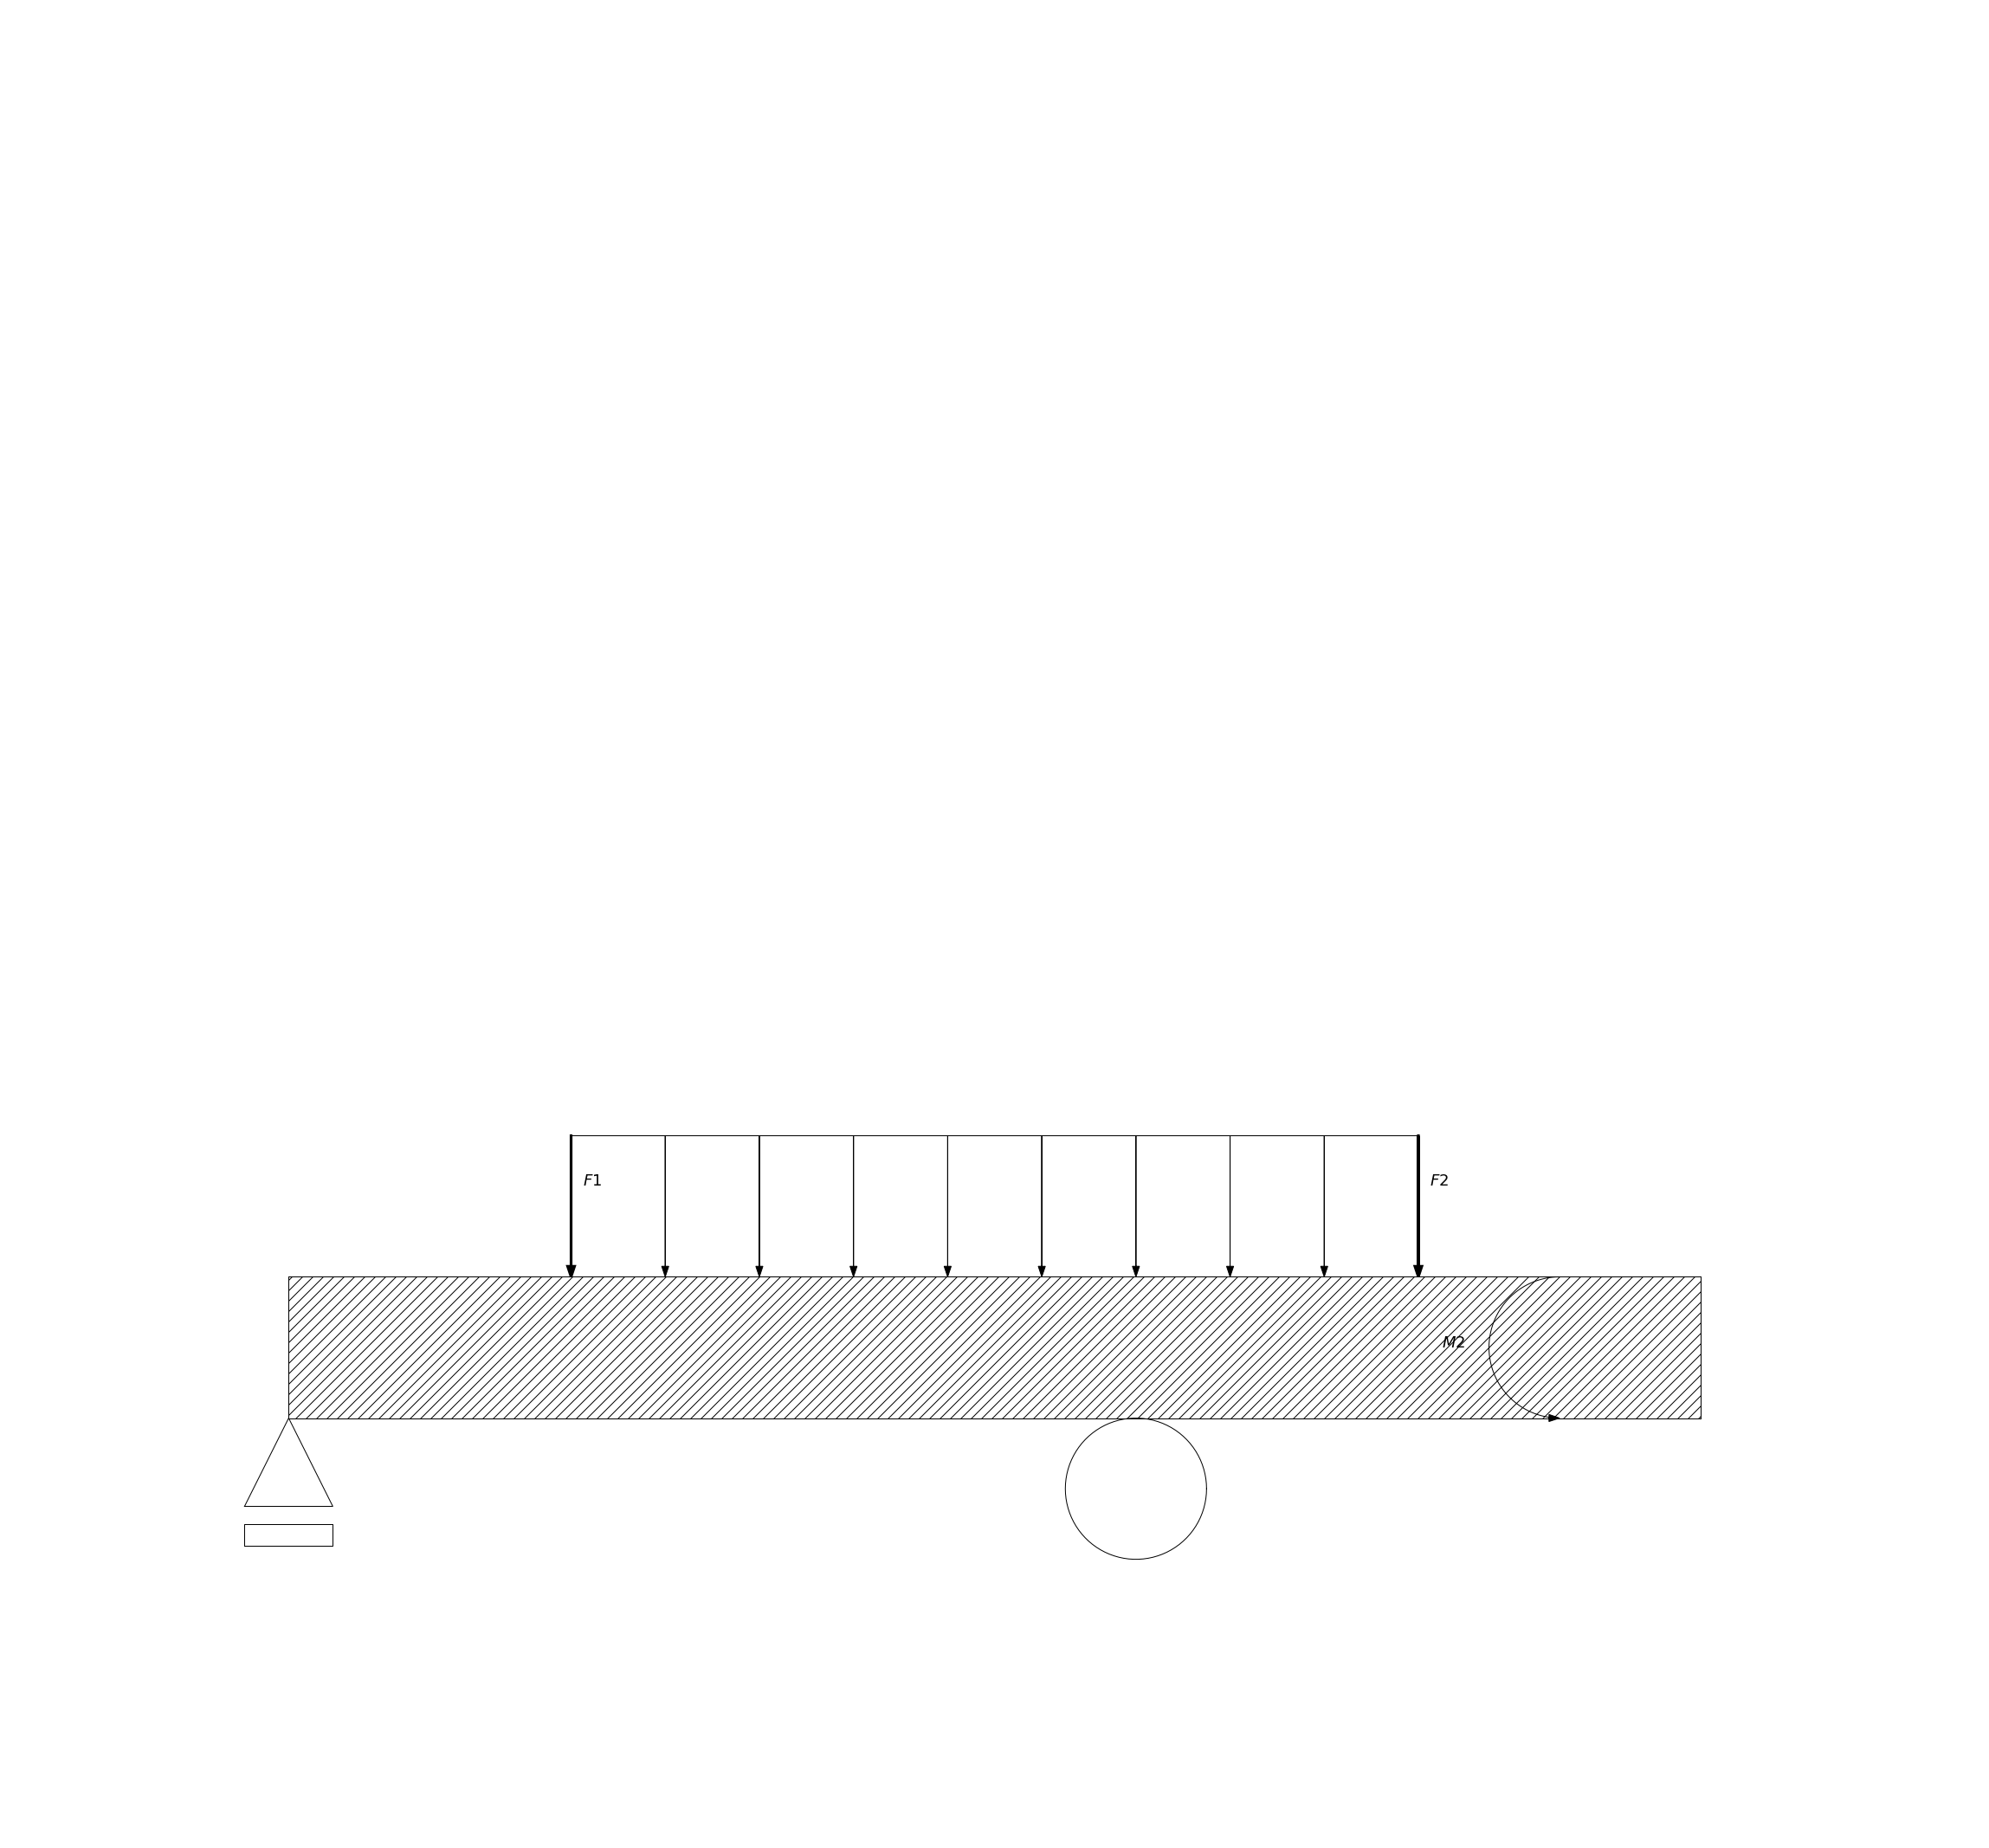

C:\Users\Felipes PC\anaconda3\lib\site-packages\pysketcher\backend\matplotlib\_matplotlib_backend.py:68: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



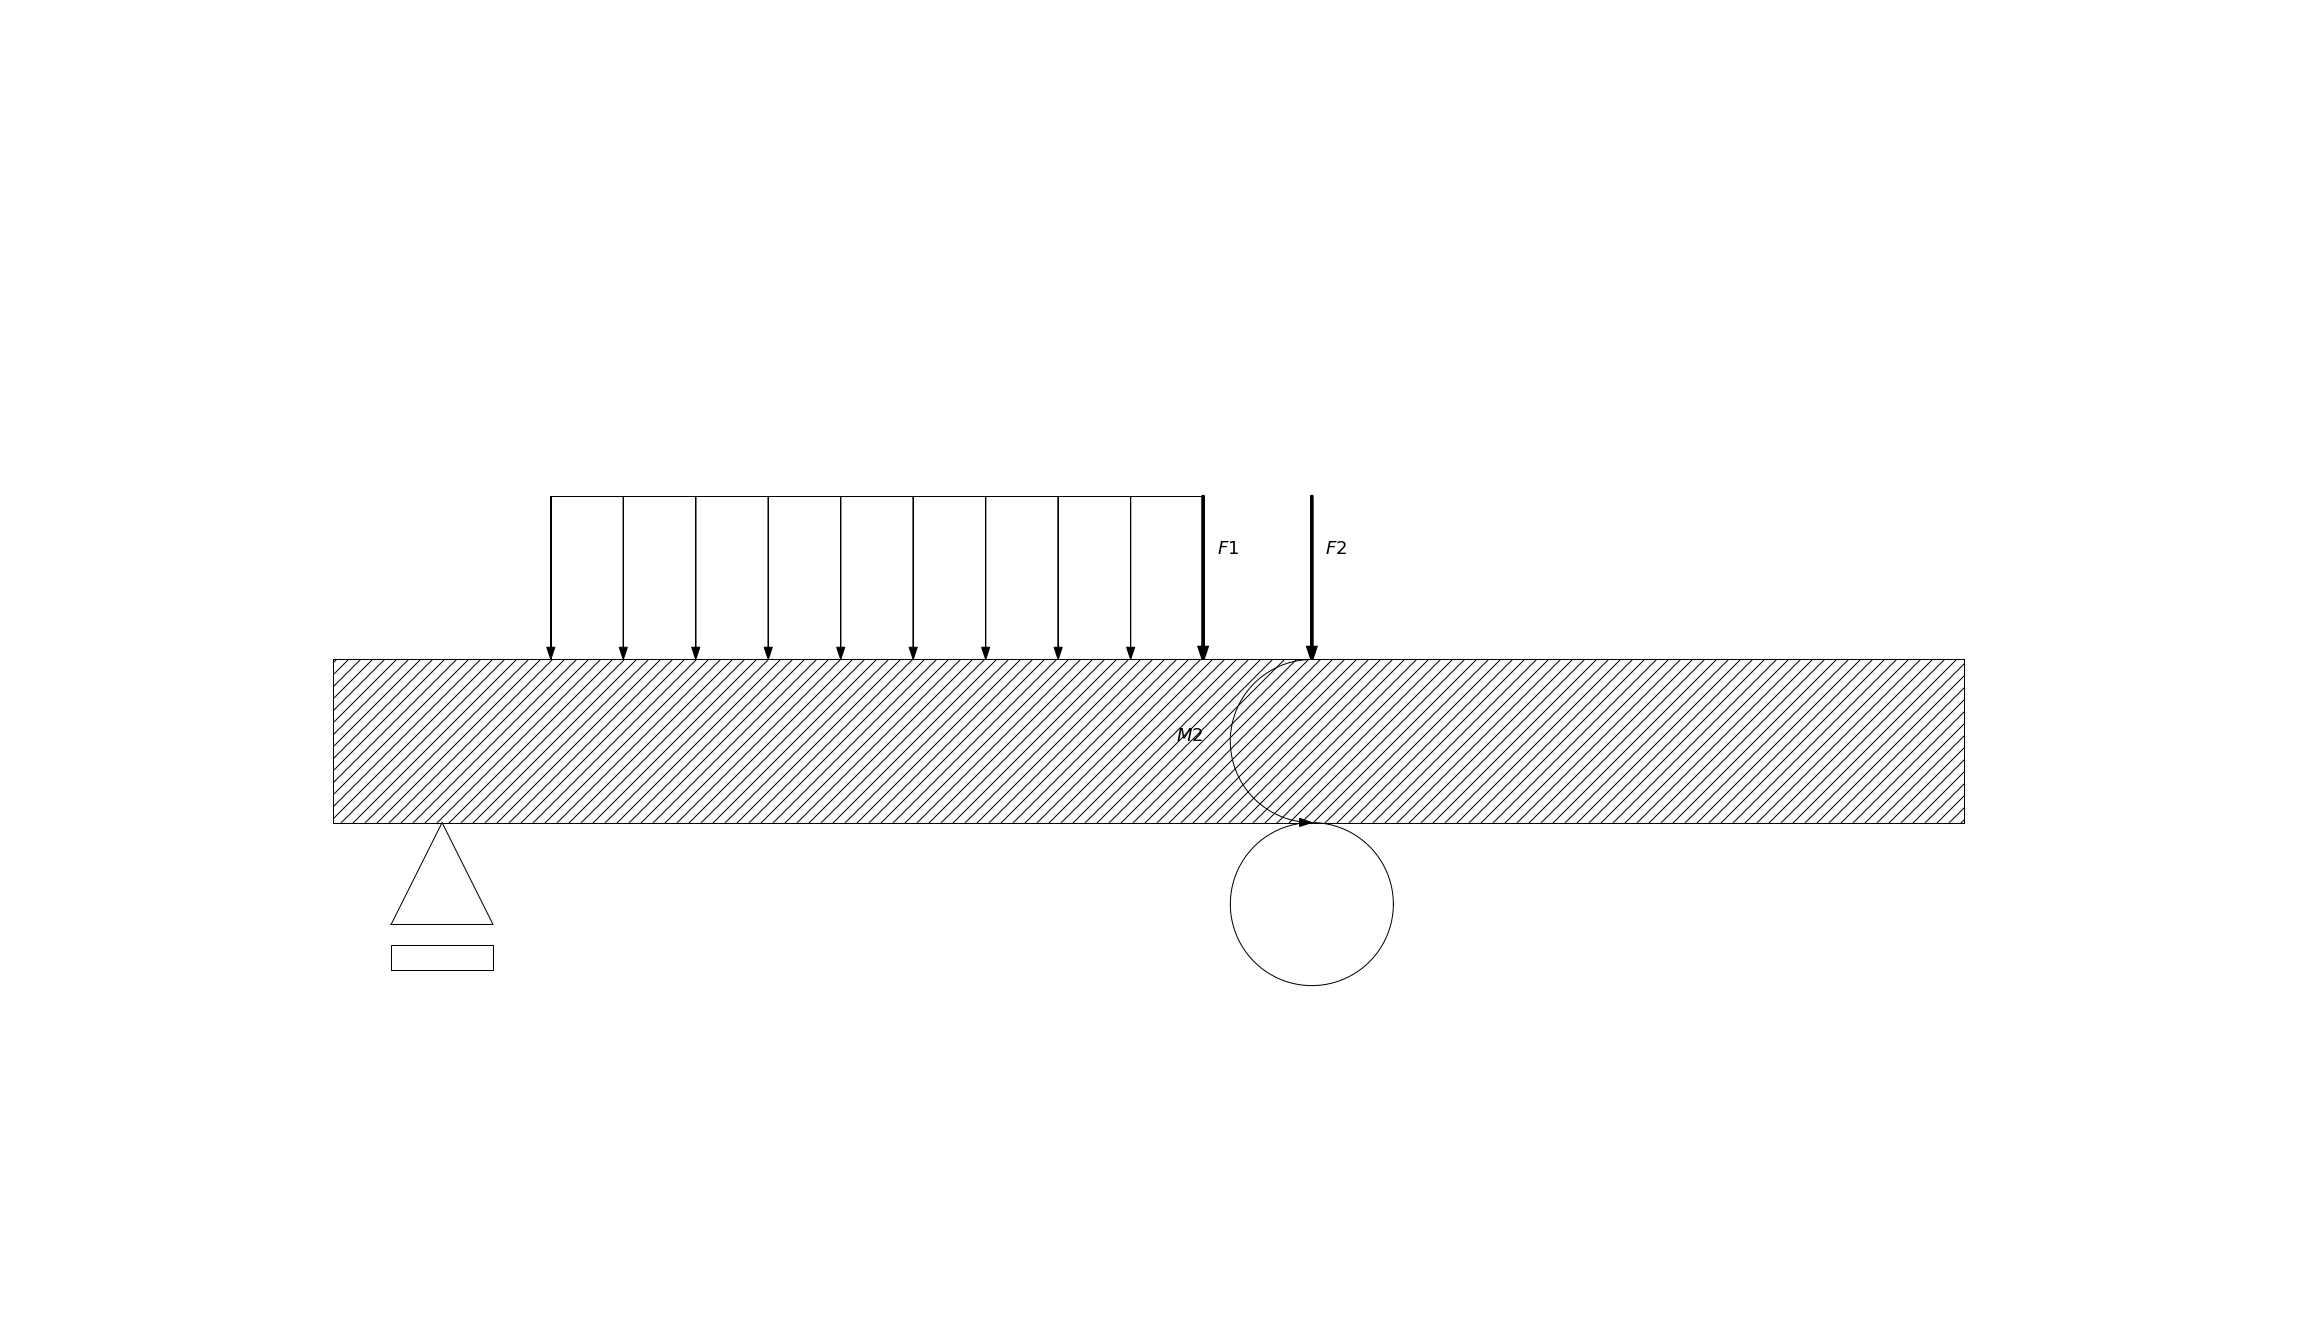

In [132]:
#Create the Beam Object
sick_beam = Beam(length = 15, height = 1)

#Adding forces onto the beam. It doesn't matter that order in which use these methods. 
sick_beam.point_force("F1",position = 8,magnitude= -2)
sick_beam.point_force("F2",position = 9,magnitude= 15)
sick_beam.uniform_load('UF1',start= 2,end = 8, distributed_load = 15)

#Adding Supports underneath the beam. The problem is limited to one fixed support
#Since adding more will make the problem statically indeterminate.
sick_beam.fixed_support('SUP1', position= 1)
sick_beam.roller_support('SUP2', position= 9)

#Add a couple onto the beam
sick_beam.moment('M2',position=9,magnitude=9)

#Once you've added the methods desired you can take a look at how the beam looks.
sick_beam.force_dictionary
sick_beam.moment_dictionary

sick_beam.show_beam()